# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

In [1]:
#!g1.1
from celeba_loader import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os
from torch import nn

from torch import Tensor

device_str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device_str)
print(f"Working with {device!r}")

Working with device(type='mps')


In [2]:
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    t_normalize,
])

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    root_dir="data/celeba",
    transform=transform,
    #subset_size=1000
)

print(f"{len(dataset)=}")
img = dataset[0]

len(dataset)=202599


### Визуализация датасета

In [3]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

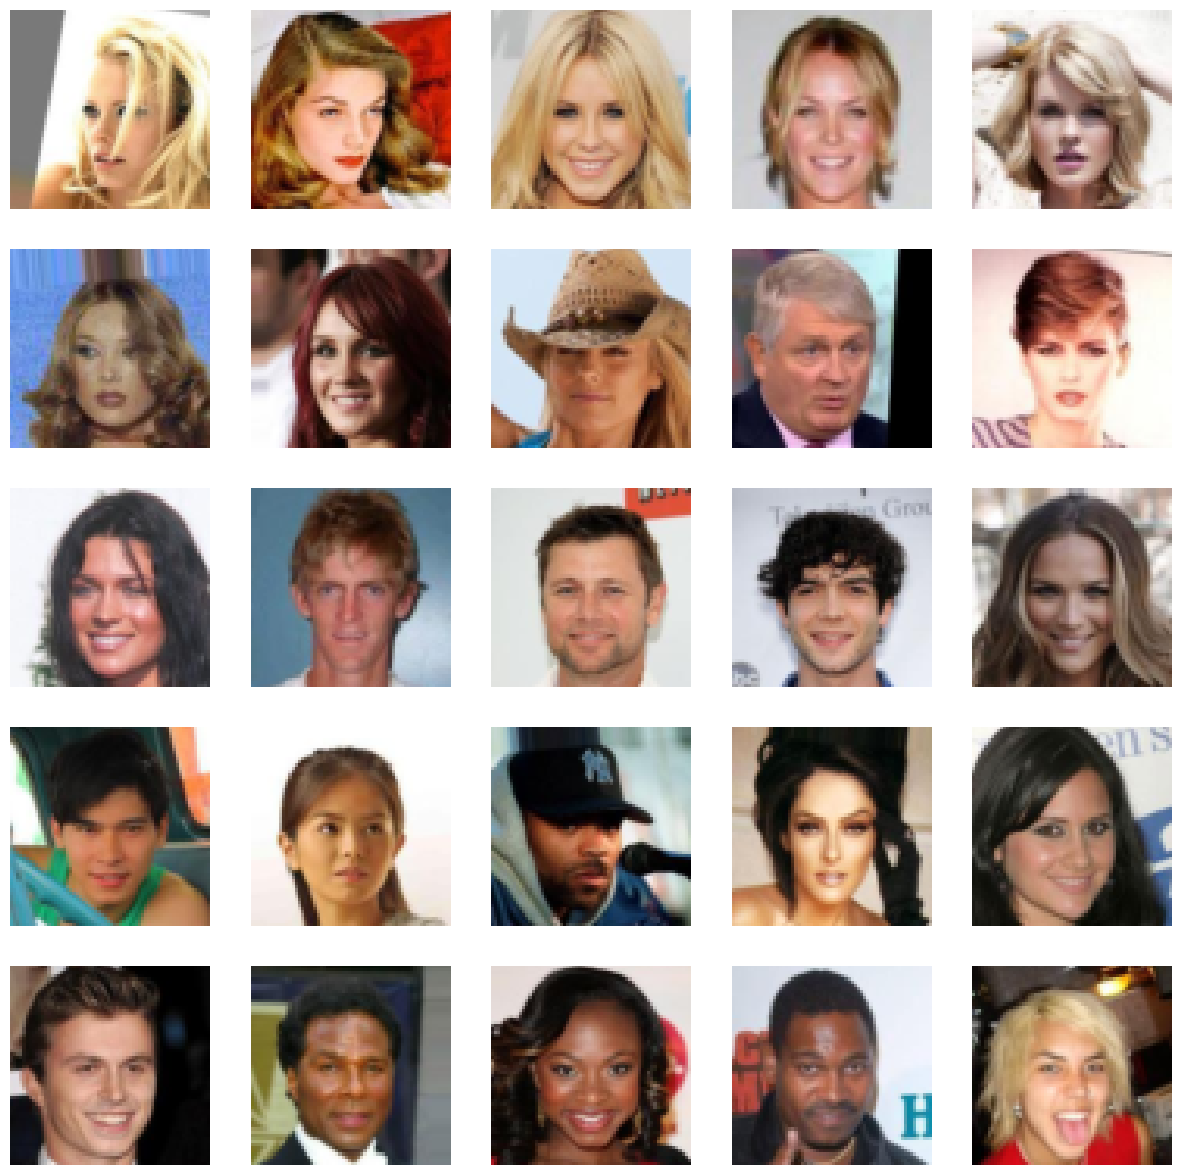

In [4]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

# Calculate FID from images for all methods

In [3]:
import torch
import torch.nn.functional as F
from scipy.linalg import sqrtm
from torchvision.models import inception_v3, Inception_V3_Weights

def calculate_fid(real_images: torch.Tensor, fake_images: torch.Tensor) -> np.float64:
    inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=False).to(device)
    inception_model.eval()

    def extract_features(images: torch.Tensor):
        with torch.no_grad():
            images = images.to(device)
            images = t_invnormalize(images).clamp(0, 1) # should be [0, 1]

            # Inception V3 requires 299x299
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
            return inception_model(images).cpu().numpy()

    real_features = extract_features(real_images)
    fake_features = extract_features(fake_images)

    mu_real, mu_fake  = np.mean(real_features, axis=0), np.mean(fake_features, axis=0)
    sigma_real, sigma_fake = np.cov(real_features, rowvar=False), np.cov(fake_features, rowvar=False)

    covmean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    diff = mu_real - mu_fake
    return diff @ diff.T + np.trace(sigma_real + sigma_fake - 2 * covmean)

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [15]:
from pathlib import Path
nf_flow_path = Path('nflow_trained.pth')


import torch
import torch.nn as nn
import torch.optim as optim
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms import CompositeTransform, MaskedAffineAutoregressiveTransform

def build_and_train_flow(epochs=10):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=0)

    num_layers = 5
    latent_dim = 3 * 64 * 64
    hidden_features = 256

    transforms = []
    for _ in range(num_layers):
        transform = MaskedAffineAutoregressiveTransform(features=latent_dim, hidden_features=hidden_features)
        transforms.append(transform)

    composite_transform = CompositeTransform(transforms)
    base_dist = StandardNormal(shape=(latent_dim,))

    flow = Flow(transform=composite_transform, distribution=base_dist).float().to(device)
    optimizer = optim.Adam(flow.parameters(), lr=1e-3)

    for epoch in range(epochs):
        total_loss = 0.0
        pbar = tqdm(dataloader)
        for batch in pbar:
            batch = batch.to(device)
            batch = batch.view(batch.size(0), -1)
            optimizer.zero_grad()
            loss = -flow.log_prob(batch).mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")
        torch.save(flow, f'nf/nflow_small_{epoch}.pth')
    return flow

if nf_flow_path.exists():
    flow = torch.load(nf_flow_path, weights_only=False).to(device)
else:
    flow = build_and_train_flow()


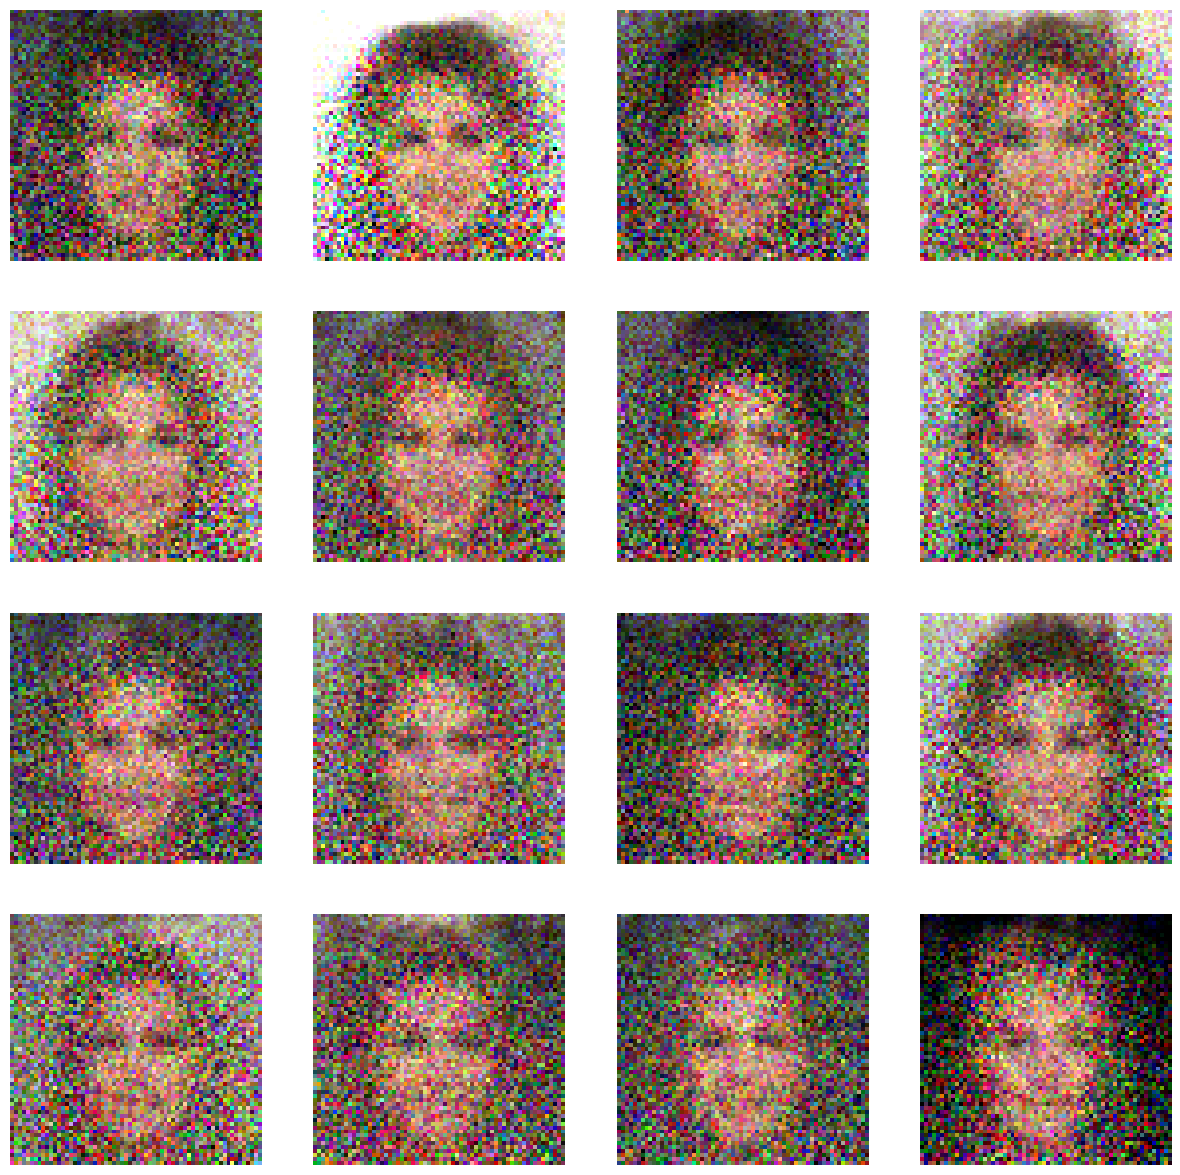

In [10]:
num_samples = 16
with torch.no_grad():
    generated = flow.sample(num_samples=num_samples)
    generated = generated.view(num_samples, 3, 64, 64)

def plot_img(img, transform):
    plt.imshow(transform(img).cpu().permute(1, 2, 0))
    plt.axis('off')

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plot_img(generated[i], lambda x: t_invnormalize(x).clamp(0, 1))
plt.show()

In [16]:
import random
num_samples = 1000
real_images = torch.stack([random.choice(dataset) for _ in range(num_samples)], dim=0)

print("Gathered real_images")
flow.eval()
with torch.no_grad():
    fake_images = flow.sample(num_samples=num_samples)
    fake_images = fake_images.view(num_samples, 3, 64, 64)

print("Generated fake images")

fid = calculate_fid(real_images, fake_images)
print(f"{fid=}")

Gathered real_images
Generated fake images
fid=np.float64(1247.9629964429323)


### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),# 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),# 8 -> 4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        # Полносвязный слой перед декодером
        self.fc_dec = nn.Linear(latent_dim, 256 * 4 * 4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),    # 32 -> 64
            nn.Tanh()  # выход в диапазоне [-1, 1], как и наши нормализованные изображения
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(z.size(0), 256, 4, 4)
        x_recon = self.decoder(h)
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss_function(x_recon, x, mu, logvar):
    # MSE как восстановительная ошибка
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    # KL-дивергенция
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

In [12]:
import torch
from pathlib import Path

vae_trained_path = Path("vae_trained.pth")

def build_and_train_vae(epochs=10):
    os.makedirs("vae", exist_ok=True)

    vae = VAE(latent_dim=256).to(device)
    vae.train()
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)
    for epoch in range(epochs):
        train_loss = 0
        for batch in (pbar := tqdm(dataloader)):
            batch = batch.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(batch)
            loss, recon_loss, kl_loss = vae_loss_function(recon, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        torch.save(vae, f'vae/vae_{epoch}.pth')
        print(f"Epoch {epoch+1}, Loss: {train_loss/len(dataloader.dataset):.4f}")
    return vae


if vae_trained_path.exists():
    vae = torch.load(vae_trained_path, weights_only=False).to(device)
else:
    vae = build_and_train_vae()


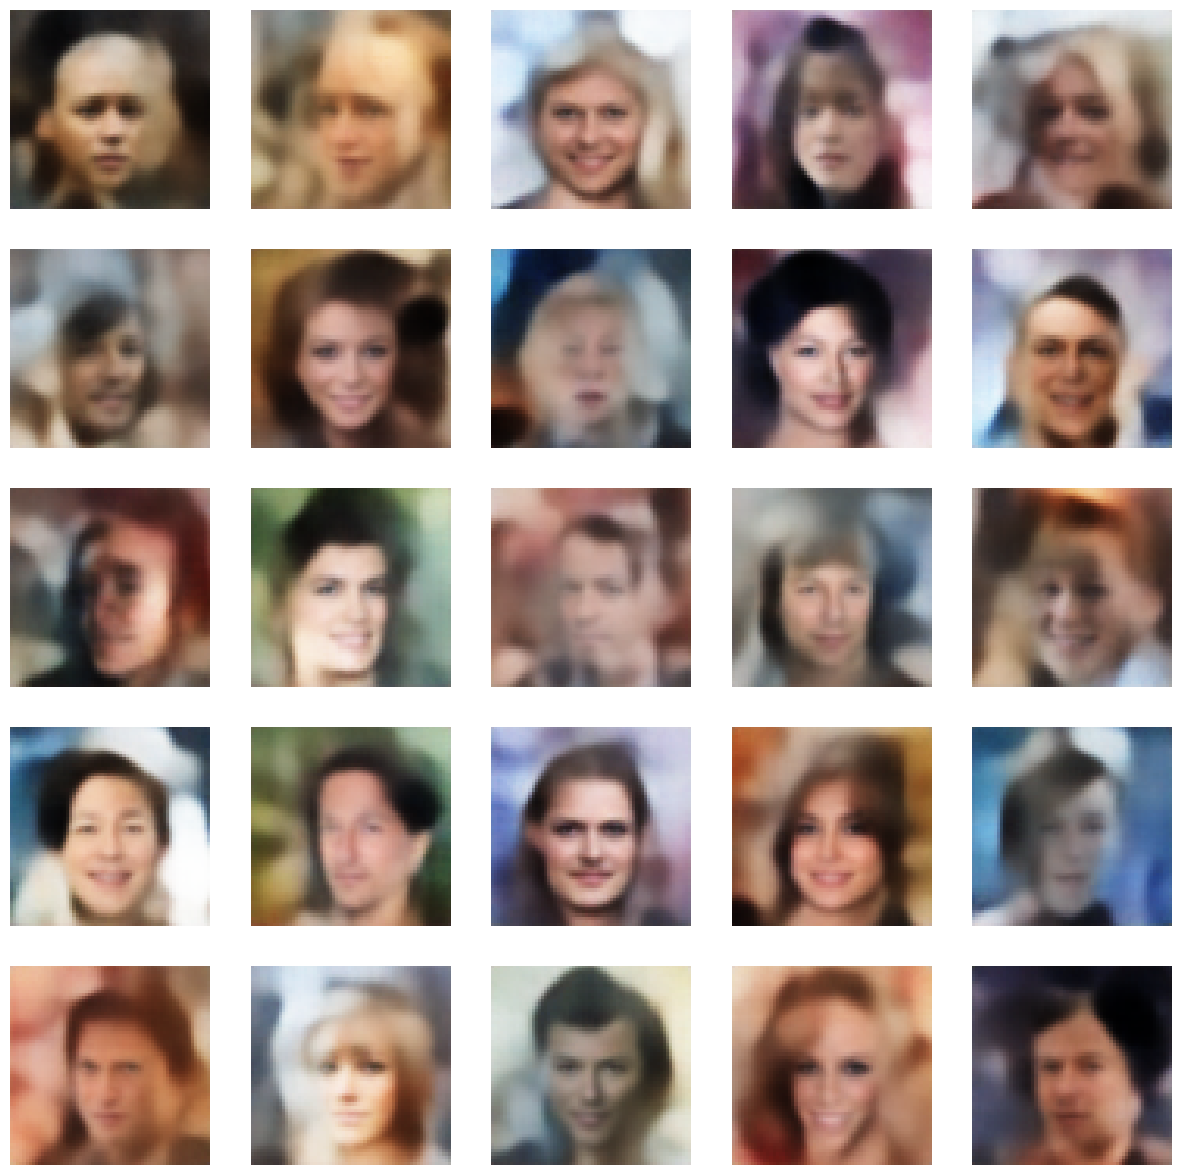

In [14]:
num_samples = 25
vae.eval()
with torch.no_grad():
    z = torch.randn(num_samples, vae.latent_dim).to(device)
    generated_images = vae.decode(z).cpu()

def plot_img(img, transform):
    plt.imshow(transform(img).cpu().permute(1, 2, 0))
    plt.axis('off')

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plot_img(generated_images[i], lambda x: t_invnormalize(x).clamp(0, 1))
plt.show()

In [12]:
import random
num_samples = 1000

#dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True, num_workers=0)
# real_images = []

# real_images.append(next(iter(dataloader)))
# real_images = torch.cat(real_images, dim=0)[:num_samples]
real_images = torch.stack([random.choice(dataset) for _ in range(num_samples)], dim=0)

print("Gathered real_images")

vae.eval()
with torch.no_grad():
    z = torch.randn(num_samples, vae.latent_dim).to(device)
    fake_images = vae.decode(z).cpu()

print("Generated fake images")

fid = calculate_fid(real_images, fake_images)
print(f"{fid=}")

Gathered real_images
Generated fake images
fid=np.float64(863.4437538323099)


### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

In [3]:
# 1. Энкодер: свёрточная сеть для получения μ и log(σ²)
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # 32 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 8 -> 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(512 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# 2. Декодер: сеть на основе ConvTranspose2d для генерации изображения из латентного кода
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 8 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 32 -> 64
            nn.Tanh(),  # поскольку изображения нормализованы в диапазоне [-1, 1]
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_recon = self.deconv(h)
        return x_recon

# 3. Простой coupling layer для нормализующего потока (RealNVP-style)
class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super(CouplingLayer, self).__init__()
        self.dim = dim
        # Разбиваем входной вектор на две части (предполагаем, что latent_dim четный)
        self.net = nn.Sequential(
            nn.Linear(dim // 2, 128),
            nn.ReLU(),
            nn.Linear(128, dim // 2 * 2)  # Выдаем и s (scale), и t (shift)
        )

    def forward(self, z, reverse=False):
        # Разбиваем на две части
        z1, z2 = z.chunk(2, dim=1)
        h = self.net(z1)
        s, t = h.chunk(2, dim=1)
        # Ограничим масштаб, например, tanh
        s = torch.tanh(s)
        if not reverse:
            z2 = z2 * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            z2 = (z2 - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det

# 4. Нормализующий поток как последовательность coupling layers
class Flow(nn.Module):
    def __init__(self, latent_dim, n_layers=4):
        super(Flow, self).__init__()
        self.layers = nn.ModuleList([CouplingLayer(latent_dim) for _ in range(n_layers)])

    def forward(self, z):
        log_det_total = 0
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_total += log_det
        return z, log_det_total

# 5. Полная модель VAPNEV, объединяющая энкодер, поток и декодер
class VAPNEV(nn.Module):
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim

        super(VAPNEV, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.flow = Flow(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Получаем параметры латентного распределения
        mu, logvar = self.encoder(x)
        # Сэмплируем базовый латентный вектор
        z0 = self.reparameterize(mu, logvar)
        # Пропускаем через нормализующий поток
        z_flow, log_det = self.flow(z0)
        # Генерируем изображение
        x_recon = self.decoder(z_flow)
        return x_recon, mu, logvar, log_det

# --- Функция потерь ---
def vapnev_loss_function(x, x_recon, mu, logvar, log_det):
    # Например, используем MSE для реконструкции
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    # Классический KL-дивергенция для VAE
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Скорректированный KL с учетом нормализующего потока (лог-детерминант)
    total_loss = recon_loss + kl_loss - log_det.sum()
    return total_loss

In [4]:
import torch
from pathlib import Path

vapnev_trained_path = Path("vapnev_trained.pth")

def build_and_train_vapnev(epochs=10):
    os.makedirs("vapnev", exist_ok=True)

    vapnev = VAPNEV(latent_dim=256).to(device)
    optimizer = torch.optim.Adam(vapnev.parameters(), lr=1e-3, weight_decay=1e-5)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

    vapnev.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in (pbar := tqdm(dataloader)):
            batch = batch.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar, log_det = vapnev(batch)
            loss = vapnev_loss_function(batch, x_recon, mu, logvar, log_det)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        torch.save(vapnev, f'vapnev/vapnev_{epoch}.pth')
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataset):.4f}")
    return vapnev


if vapnev_trained_path.exists():
    vapnev = torch.load(vapnev_trained_path, weights_only=False).to(device)
else:
    vapnev = build_and_train_vapnev()

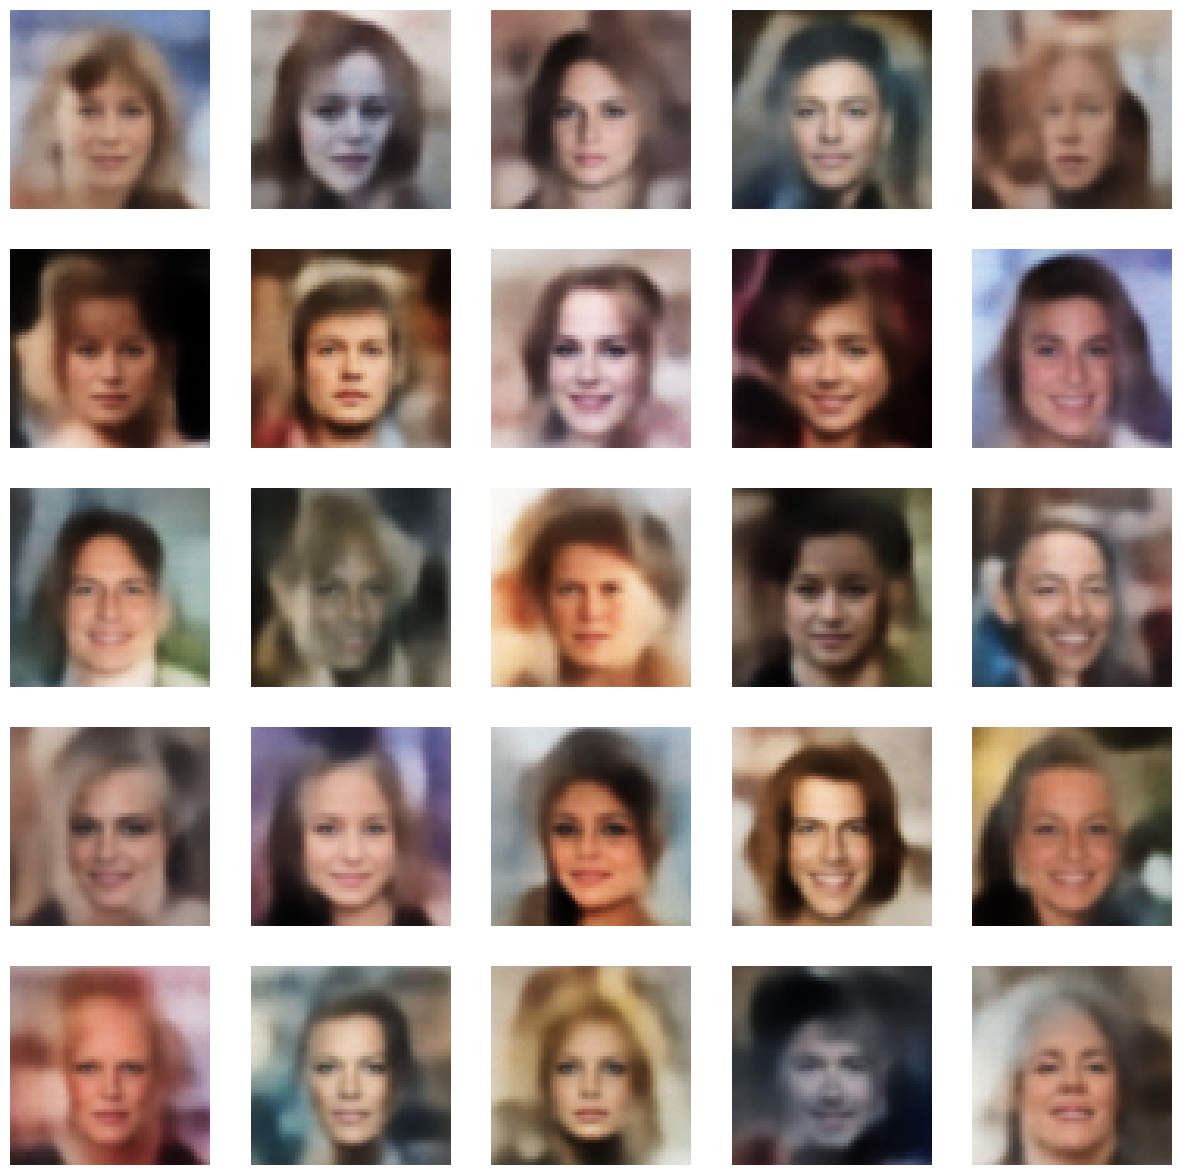

In [5]:
vapnev.eval()
num_samples = 25
with torch.no_grad():
    # Сэмплируем латентный вектор из стандартного нормального распределения
    z = torch.randn(num_samples, vapnev.latent_dim).to(device)
    z_flow, _ = vapnev.flow(z)
    generated = vapnev.decoder(z_flow)

def plot_img(img, transform):
    plt.imshow(transform(img).cpu().permute(1, 2, 0))
    plt.axis('off')

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plot_img(generated[i], lambda x: t_invnormalize(x).clamp(0, 1))
plt.show()

In [9]:
import random

num_samples = 1000
real_images = torch.stack([dataset[i] for i in range(num_samples)], dim=0)
print("Gathered real_images")

vapnev.eval()
with torch.no_grad():
    z = torch.randn(num_samples, vapnev.latent_dim).to(device)
    z_flow, _ = vapnev.flow(z)
    fake_images = vapnev.decoder(z_flow)

print("Generated fake images")

fid = calculate_fid(real_images, fake_images)
print(f"{fid=}")

Gathered real_images
Generated fake images
fid=np.float64(907.8049434345089)


#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [4]:
# 1. Условный энкодер: принимает изображение и условие (например, метку класса)
class ConditionalEncoder(nn.Module):
    def __init__(self, latent_dim, num_classes, condition_dim=50):
        super(ConditionalEncoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),   # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # 8 -> 4
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        # Эмбеддинг для условной информации (например, меток классов)
        self.embedding = nn.Embedding(num_classes, condition_dim)
        # Вместо 512*4*4 вход теперь имеет дополнительное условие
        self.fc_mu = nn.Linear(512 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(512 * 4 * 4 + condition_dim, latent_dim)

    def forward(self, x, y):
        h = self.conv(x)
        h = h.view(x.size(0), -1)
        y_embed = self.embedding(y)  # y имеет размер (batch,)
        h = torch.cat([h, y_embed], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# 2. Условный декодер: принимает латентный вектор и условие, затем генерирует изображение
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, num_classes, condition_dim=50):
        super(ConditionalDecoder, self).__init__()
        self.embedding = nn.Embedding(num_classes, condition_dim)
        self.fc = nn.Linear(latent_dim + condition_dim, 512 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1), # 4 -> 8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 8 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16 -> 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),    # 32 -> 64
            nn.Tanh(),  # изображения нормализованы в диапазоне [-1, 1]
        )

    def forward(self, z, y):
        y_embed = self.embedding(y)
        z = torch.cat([z, y_embed], dim=1)
        h = self.fc(z)
        h = h.view(z.size(0), 512, 4, 4)
        x_recon = self.deconv(h)
        return x_recon

# 3. Условный coupling layer для нормализующего потока
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, dim, num_classes, condition_dim=50):
        super(ConditionalCouplingLayer, self).__init__()
        self.dim = dim
        self.embedding = nn.Embedding(num_classes, condition_dim)
        # На вход подаётся половина латентного вектора + эмбеддинг условия
        self.net = nn.Sequential(
            nn.Linear(dim // 2 + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, (dim // 2) * 2)  # Выдаем параметры для s и t
        )

    def forward(self, z, y, reverse=False):
        z1, z2 = z.chunk(2, dim=1)
        y_embed = self.embedding(y)
        h = torch.cat([z1, y_embed], dim=1)
        h = self.net(h)
        s, t = h.chunk(2, dim=1)
        s = torch.tanh(s)
        if not reverse:
            z2 = z2 * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            z2 = (z2 - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        z = torch.cat([z1, z2], dim=1)
        return z, log_det

# 4. Условительный нормализующий поток (flow) как последовательность coupling layers
class ConditionalFlow(nn.Module):
    def __init__(self, latent_dim, n_layers, num_classes, condition_dim=50):
        super(ConditionalFlow, self).__init__()
        self.layers = nn.ModuleList([
            ConditionalCouplingLayer(latent_dim, num_classes, condition_dim)
            for _ in range(n_layers)
        ])

    def forward(self, z, y, reverse=False):
        log_det_total = 0
        for layer in self.layers:
            z, log_det = layer(z, y, reverse)
            log_det_total += log_det
        return z, log_det_total

# 5. Полная условная модель VAPNEV
class ConditionalVAPNEV(nn.Module):
    def __init__(self, latent_dim, num_classes, condition_dim=50, n_flow_layers=4):
        super(ConditionalVAPNEV, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = ConditionalEncoder(latent_dim, num_classes, condition_dim)
        self.decoder = ConditionalDecoder(latent_dim, num_classes, condition_dim)
        self.flow = ConditionalFlow(latent_dim, n_flow_layers, num_classes, condition_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        # Получаем параметры распределения из условного энкодера
        mu, logvar = self.encoder(x, y)
        z0 = self.reparameterize(mu, logvar)
        # Пропускаем базовый латентный вектор через условный нормализующий поток
        z_flow, log_det = self.flow(z0, y)
        # Генерируем изображение с учётом условия
        x_recon = self.decoder(z_flow, y)
        return x_recon, mu, logvar, log_det

# Функция потерь (аналогична базовой версии)
def conditional_vapnev_loss_function(x, x_recon, mu, logvar, log_det):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_loss - log_det.sum()
    return total_loss

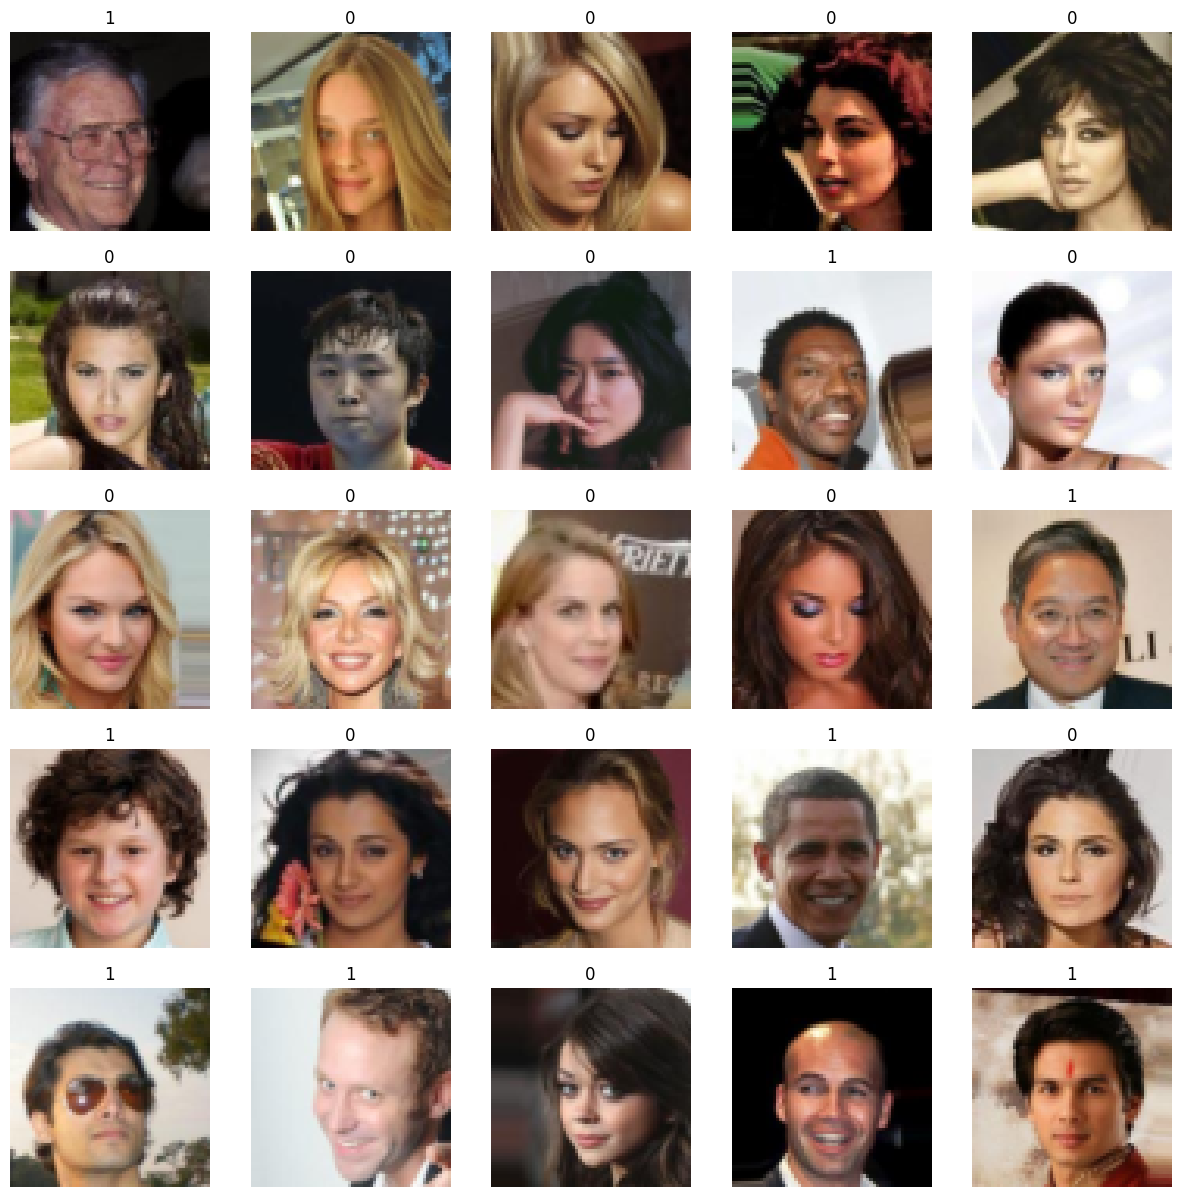

In [5]:
import random
MALE_INDEX = dataset.header.index("Male")

class CelebaMaleFemaleDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image, int(target[MALE_INDEX])

mf_dataset = CelebaMaleFemaleDataset(
    root_dir="data/celeba",
    transform=transform,
    #subset_size=1000
)

plt.figure(figsize=(15, 15))

for i in range(25):
    img, label = random.choice(mf_dataset)
    plt.subplot(5, 5, i + 1)
    plt.imshow(t_invnormalize(img).permute(1, 2, 0))
    plt.axis('off')
    plt.title(label)
plt.show()

In [6]:
from pathlib import Path
conditional_vapnev_trained_path = Path("conditional_vapnev_trained.pth")


def build_and_train_conditional_vapnev(epochs=10):
    os.makedirs("conditional_vapnev", exist_ok=True)

    model = ConditionalVAPNEV(latent_dim=256, num_classes=2, condition_dim=50).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    dataloader = torch.utils.data.DataLoader(mf_dataset, batch_size=256, shuffle=True, num_workers=0)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in (pbar := tqdm(dataloader)):
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar, log_det = model(x, y)
            loss = conditional_vapnev_loss_function(x, x_recon, mu, logvar, log_det)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_description(f'Epoch {epoch}, Loss: {loss.item():.4f}')
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(dataset):.4f}")
        torch.save(model, f'conditional_vapnev/conditional_vapnev_{epoch}.pth')
    return model

if conditional_vapnev_trained_path.exists():
    conditional_vapnev = torch.load(conditional_vapnev_trained_path, weights_only=False).to(device)
else:
    conditional_vapnev = build_and_train_conditional_vapnev()


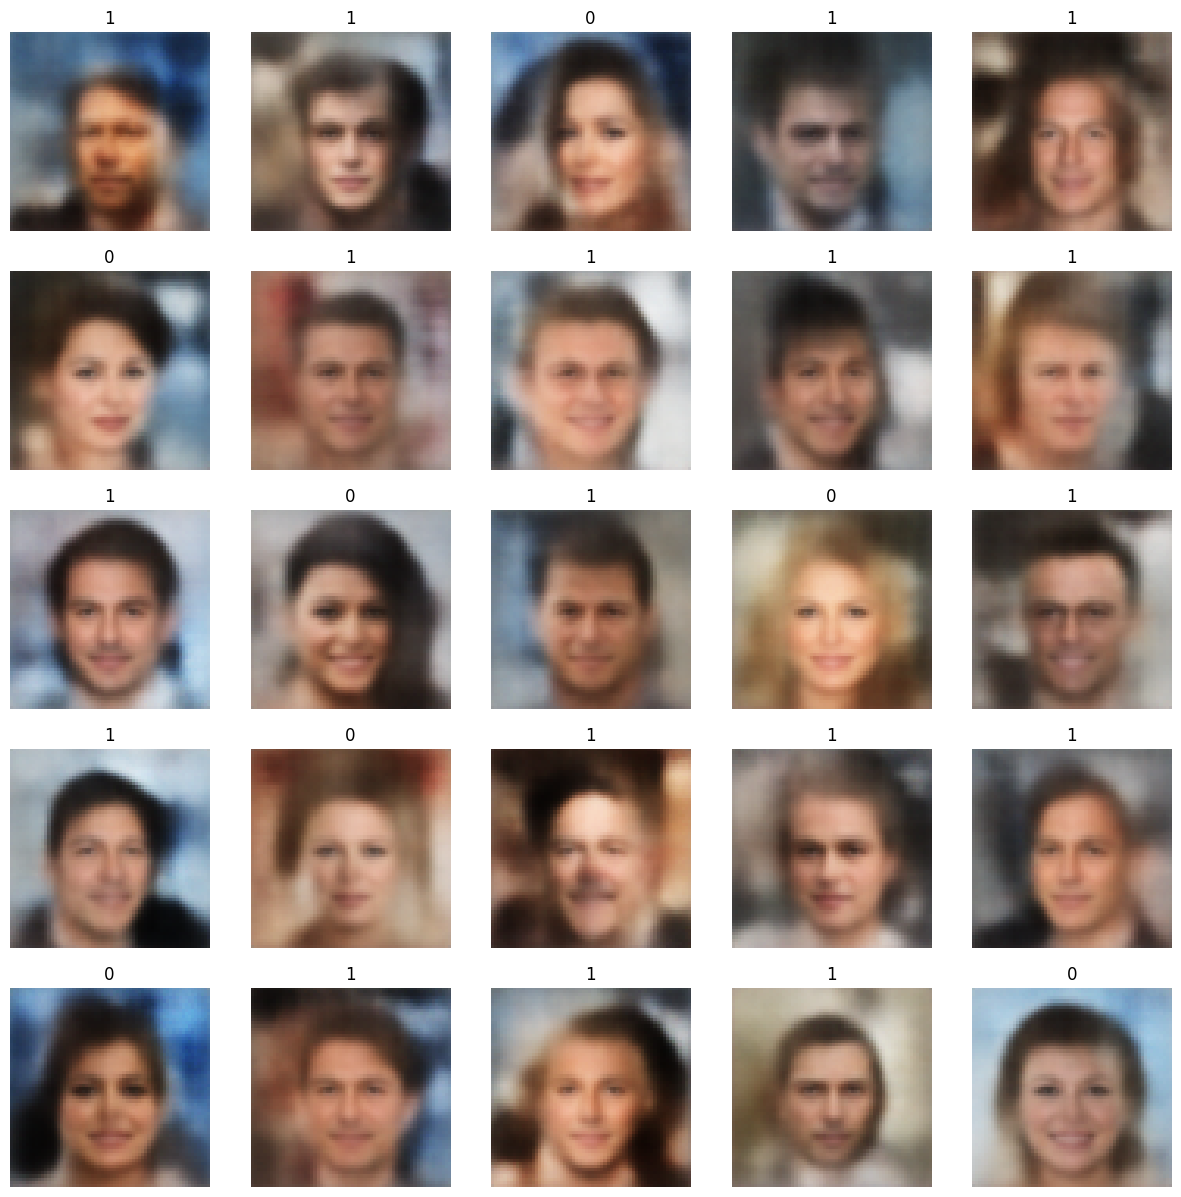

In [7]:
num_samples = 25

labels = torch.randint(0, 2, (num_samples,), dtype=torch.long, device=device)
conditional_vapnev.eval()
with torch.no_grad():
    # Сэмплируем латентный вектор из стандартного нормального распределения
    z = torch.randn(num_samples, conditional_vapnev.latent_dim).to(device)
    z_flow, _ = conditional_vapnev.flow(z, labels)
    generated = conditional_vapnev.decoder(z_flow, labels)


plt.figure(figsize=(15, 15))
for i in range(num_samples):
    img, label = random.choice(mf_dataset)
    plt.subplot(5, 5, i + 1)
    plt.imshow(t_invnormalize(generated[i]).clamp(0, 1).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(int(labels[i]))
plt.show()

# FEMALE

In [8]:
import random

num_samples = 1000
real_images = []
while len(real_images) < num_samples:
    img, gender = random.choice(mf_dataset)
    if gender == 0:
        real_images.append(img)
real_images = torch.stack(real_images, dim=0)

print("Gathered real_images")

labels = torch.full((num_samples, ), 0, dtype=torch.long, device=device)
conditional_vapnev.eval()
with torch.no_grad():
    # Сэмплируем латентный вектор из стандартного нормального распределения
    z = torch.randn(num_samples, conditional_vapnev.latent_dim).to(device)
    z_flow, _ = conditional_vapnev.flow(z, labels)
    fake_images = conditional_vapnev.decoder(z_flow, labels)

print("Generated fake images")

fid = calculate_fid(real_images, fake_images)
print(f"{fid=}")

Gathered real_images
Generated fake images
fid=np.float64(546.9577869890973)


# MALE

In [10]:
import random

num_samples = 1000
real_images = []
while len(real_images) < num_samples:
    img, gender = random.choice(mf_dataset)
    if gender == 1:
        real_images.append(img)
real_images = torch.stack(real_images, dim=0)

print("Gathered real_images")

labels = torch.full((num_samples, ), 1, dtype=torch.long, device=device)
conditional_vapnev.eval()
with torch.no_grad():
    # Сэмплируем латентный вектор из стандартного нормального распределения
    z = torch.randn(num_samples, conditional_vapnev.latent_dim).to(device)
    z_flow, _ = conditional_vapnev.flow(z, labels)
    fake_images = conditional_vapnev.decoder(z_flow, labels)

print("Generated fake images")

fid = calculate_fid(real_images, fake_images)
print(f"{fid=}")

Gathered real_images
Generated fake images
fid=np.float64(1221.8180745204747)


### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

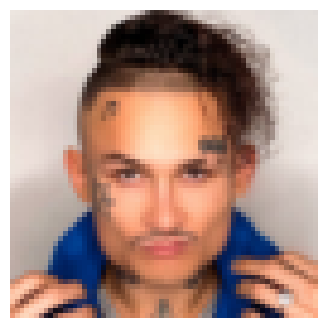

torch.Size([3, 64, 64])

In [80]:
from PIL import Image
import torchvision.transforms.functional as F

morgen_img = transforms.Compose([
    transforms.Lambda(lambda img: F.crop(img, 30, 100, 450, 450)),
    transforms.Resize(64),
    #transforms.CenterCrop(64, ),
    transforms.ToTensor(),
    t_normalize,
])(
    Image.open('morgen.jpg').convert("RGB")
)

plt.figure(figsize=(4, 4))
plt.imshow(t_invnormalize(morgen_img).cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

morgen_img.shape

In [ ]:
import numpy
vapnev.eval()
morgen_batch = torch.stack([morgen_img], dim=0).to(device)
with torch.no_grad():
    z_morgen, _ = vapnev.encoder(morgen_batch)
    z_flow_morgen, _ = vapnev.flow(z_morgen)

    top_k = 5
    best = []
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        z, _ = vapnev.encoder(batch)
        z_flow, _ = vapnev.flow(z)

        cur_dist = torch.norm(z_morgen - z).cpu().numpy()

        if len(best) < top_k:
            best.append((cur_dist, batch))
            best.sort(key=lambda x: x[0])
        else:
            if cur_dist < best[-1][0]:
                best[-1] = (cur_dist, batch)
                best.sort(key=lambda x: x[0])


    # z = torch.randn(num_samples, vapnev.latent_dim).to(device)
    # z_flow, _ = vapnev.flow(z)
    # generated = vapnev.decoder(z_flow)

  0%|          | 0/202599 [00:00<?, ?it/s]

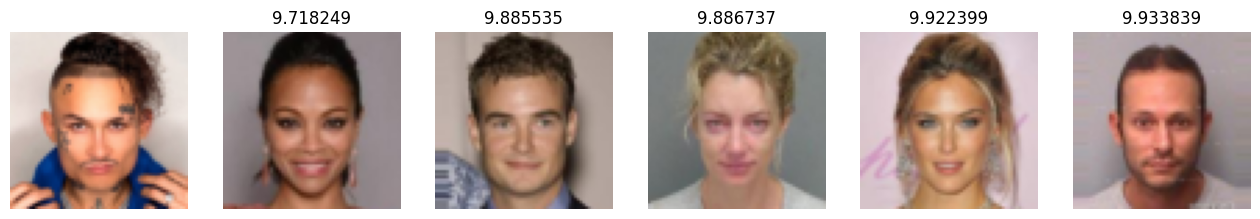

In [65]:
plt.figure(figsize=(16, 16))
plt.subplot(1, len(best) + 1, 1)
plt.imshow(t_invnormalize(morgen_batch[0]).clamp(0, 1).cpu().permute(1, 2, 0))
plt.axis('off')

for i, (dist, batch) in enumerate(best):
    plt.subplot(1, len(best) + 1, i + 2)
    plt.imshow(t_invnormalize(batch[0]).clamp(0, 1).cpu().permute(1, 2, 0))
    plt.title(dist)
    plt.axis('off')
plt.show()

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.